In [1]:
#Numpy
import numpy as np
#Scipy
from scipy import special as scsp
from scipy import stats
from numpy import random as rdm
#Pyplot
import matplotlib.pyplot as plt
#Multi-CPU job
from joblib import Parallel, delayed
import multiprocessing as mpg
#Time
import time
#Json
import json
#Os for file management
import os.path

RERUN = False #To rerun all computations (False will load from file if they exist)
extension = '.png' #fig file extension
DIR  = 'D:/pdm_data/'

# Stochastic processes

##### Model parameters from Meyer & Bijeljic 2016

In [2]:
#Bentheimer 500 parameters
Bentheimer500 ={
'name'  : 'Bentheimer 500',
'L0'    :  1.5,      #Sample length [mm]
'Deltax':  3.0,      #Resolution [um]
'n'     :  500,      #Nb of 1D points
'L0/L'  :  11.2,     #Pore length ratio [-]
'phi'   :  0.21,     #Porosity [%]
'kappa' :  1.26,     #Tortuosity [-]
'lmbd/L':  8.33,     #Correlation length [-]
#Theta angle model
'omegat':  5.0,
'taut'  :  0.093,
'sigmat':  0.59,
'mut'   :  41.0,
#Beta angle model
'taub'  :  0.11,
'bb'    :  2.0,
#Log velocity magnitude model
'b'     :  0.56,
'c'     :  1.1,
'alpha' : -4.7,
'mu'    :  1.5,
'sigma' :  2.7
}
#Bentheimer 1000 parameters
Bentheimer1000 ={
'name'  :  'Bentheimer 1000',
'L0'    :  3.0,      #Sample length [mm]
'Deltax':  3.0,      #Resolution [um]
'n'     :  1000,     #Nb of 1D points
'L0/L'  :  22.6,     #Pore length ratio [-]
'phi'   :  0.22,     #Porosity [%]
'kappa' :  1.65,     #Tortuosity
'lmbd/L':  8.32,     #Correlation length [-]
#Theta angle model
'omegat':  4.3,
'taut'  :  0.12,
'sigmat':  0.69,
'mut'   :  38.0,
#Beta angle model
'taub'  :  0.13,
'bb'    :  1.9,
#Log velocity magnitude model
'b'     :  0.57,
'c'     :  1.3,
'alpha' : -3.6,
'mu'    :  1.5,
'sigma' :  2.5
}
#Estaillades parameters
Estaillades = {
'name'  :  'Estaillades',
'L0'    :  3.31,     #Sample length [mm]
'Deltax':  3.31,     #Resolution [um]
'n'     :  1000,     #Nb of 1D points
'L0/L'  :  11.7,     #Pore length ratio [-]
'phi'   :  0.11,     #Porosity [%]
'kappa' :  2.26,     #Tortuosity
'lmbd/L':  36.2,     #Correlation length [-]
#Theta angle model
'omegat':  10.0,
'taut'  :  0.018,
'sigmat':  0.84,
'mut'   :  17.0,
#Beta angle model
'taub'  :  0.014,
'bb'    :  7.0,
#Log velocity magnitude model
'b'     :  0.63,
'c'     :  3.0,
'alpha' : -5.1,
'mu'    :  2.2,
'sigma' :  5.1
}

## 1) Log velocity model from Meyer and Bijeljic 2016

#### 1.1) PDF, drift and diffusion functions 
$$ p(v)=\frac{1}{\sqrt{2\pi}\sigma}\exp\left[-\frac{(v-\mu)^2}{2\sigma^2}\right](1-\textrm{erf}\left[-\frac{\alpha(v-\mu)}{\sqrt{2}\sigma}\right])$$

$$a(v)=\frac{d(v)}{2}\ln[p(v)d(v)]$$

$$d(v)=c\exp[bv]$$

In [3]:
#Skew-normal PDF
def p_skew(v,sample) :
    alpha = sample['alpha']
    mu    = sample['mu']
    sigma = sample['sigma']
    p = 1/np.sqrt(2.0*np.pi*sigma**2)*np.exp(-(v-mu)**2/(2.0*sigma**2))*scsp.erfc(-alpha*(v-mu)/np.sqrt(2.0*sigma**2))
    return p


#Diffusion function from DWM
def d(v,sample) :
    b = sample['b']
    c = sample['c']
    return c*np.exp(b*v)

#Drift function from DWM
def a(v,sample) :
    eps  = 0.1
    p_p1 = p_skew(v+eps,sample); p_m1 = p_skew(v-eps,sample);
    d_p1 = d(v+eps,sample);      d_m1 = d(v-eps,sample);
    d_   = d(v,sample);
    grad = (np.log(p_p1 * d_p1)-np.log(p_m1 * d_m1))/(2.0*eps)
    return d_/2.0 * grad

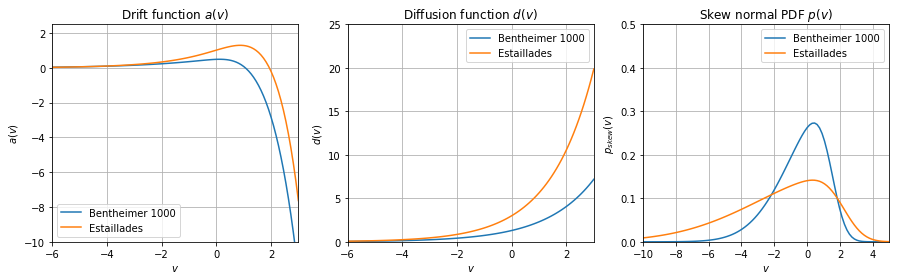

In [4]:
samples = [Bentheimer1000, Estaillades]
nv=100
(v_min, v_max) = (-6.0, 3.0)
v=np.linspace(v_min,v_max,nv)
dv= (v_max-v_min)/nv
fig, axs = plt.subplots(1,3, figsize= (15,4))

for (i,sample) in zip(range(len(samples)),samples) :
    axs[0].plot(v,a(v,sample),label = sample['name'])
    axs[1].plot(v,d(v,sample),label = sample['name'])
    axs[2].plot(np.linspace(-10,5,nv),p_skew(np.linspace(-10,5,nv),sample),label = sample['name'])

axs[0].set_title(r'Drift function $a(v)$')
axs[0].set_xlabel(r'$v$')
axs[0].set_ylabel(r'$a(v)$')
axs[0].set_xlim((-6,3))
axs[0].set_ylim((-10,2.5))
axs[0].legend()
axs[0].grid(True)

axs[1].set_title(r'Diffusion function $d(v)$')
axs[1].set_xlabel('$v$')
axs[1].set_ylabel(r'$d(v)$')
axs[1].set_xlim((-6,3))
axs[1].set_ylim((0,25))
axs[1].legend()
axs[1].grid(True)

axs[2].set_title(r'Skew normal PDF $p(v)$')
axs[2].set_xlabel('$v$')
axs[2].set_ylabel(r'$p_{skew}(v)$')
axs[2].set_xlim((-10,5))
axs[2].set_ylim((0,0.5))
axs[2].legend()
axs[2].grid(True)

plt.savefig(DIR+'Figures/MP_functions'+extension)

#### Log velocity markov process

In [5]:
#Log velocity magnitude model from Meyer and Bijeljic 2016
def LVM_process(sample, param):
    if param['seed'] is not None : 
        rdm.seed(param['seed'])
    else :
        rdm.seed()
    Tmax = param['Tmax']; dt  = param['dt']; 
    v0   = param['v0'];   csf = param['csf']; 
    Nt        = int(Tmax/dt)+1
    delta     = dt #Wiener process 
    track     = range(int(Nt/csf)) #If we do not want to track the whole evolution
    v_track   = np.zeros(int(Nt/csf)) #Resulting time serie
    v_        = v0
    for i in range(Nt) :
        if (i in track):
            v_track[i] = v_
        dv = a(v_,sample)*dt + np.sqrt(d(v_,sample))*rdm.normal(loc=0.0, scale=np.sqrt(dt), size=None)
        v_ = v_ + dv
    return v_track

def Save_data(MP_dict, filename) :
    #Copy data into non np array dict for json formating
    No_np = {}
    for key in MP_dict : No_np[key] = [v for v in MP_dict[key]]
    with open(filename, 'w') as outfile:  
        json.dump(No_np, outfile)
    
def Load_data(filename) :
    MP_dict = {}
    with open(filename, 'r') as outfile:  
        MP_dict = json.load(outfile)
    #Converting arrays in np array
    for key in MP_dict : MP_dict[key] = np.array(MP_dict[key])
    return MP_dict

## Running processes

In [6]:
samples = [Bentheimer1000, Estaillades]
Nmp = 1
MP_params = {
'seed': 12345,
'v0'  : 1.5,
'dt'  : 0.01,
'Tmax': 100.0,
'csf' : 1.0
}
MP_example  = {'params' : MP_params}

for sample in samples :
    MP_example[sample['name']]  = Parallel(n_jobs=-2)(
        delayed(LVM_process)
        (sample, MP_params) for i in range(Nmp))

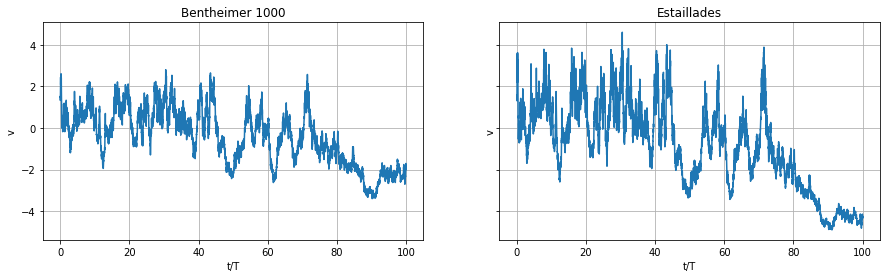

In [7]:
fig, axs = plt.subplots(1,2, sharey = True, figsize=(15,4))
for (i,sample) in zip(range(len(samples)),samples) :
    for n in range(Nmp) :
        Tmax = MP_example['params']['Tmax']
        Nt   = len(MP_example[sample['name']][n])
        timerange = np.linspace(0,Tmax,Nt)
        axs[i].plot(timerange,MP_example[sample['name']][n],'-')
        axs[i].grid(True);
        axs[i].set_ylabel('v');
        axs[i].set_xlabel('t/T');
        axs[i].set_title(sample['name']);
plt.savefig(DIR+'Figures/MP_examples'+extension)

### Process Statistics and PDF comparison

In [8]:
samples = [Bentheimer1000, Estaillades]
Nmp = 100
MP_params = {
'seed': None,
'v0'  : 1.5,
'dt'  : 0.005,
'Tmax': 300.0,
'csf' : 1.0
}
MP_lvm  = {'params' : MP_params}
fname   = DIR+'Markov_processes/MP_lvm.dat'
rerun   = False
if (not os.path.isfile(fname)) or rerun:
    for sample in samples :
        MP_lvm[sample['name']]  = Parallel(n_jobs=-2)(
            delayed(LVM_process)
            (sample, MP_params) for i in range(Nmp))
        MP_lvm[sample['name']]=np.reshape(MP_lvm[sample['name']],len(MP_lvm[sample['name']][0])*Nmp)
        Save_data(MP_lvm,fname)
else :
    print('Load data...')
    MP_lvm = Load_data(fname)
    print('Done')

Load data...
Done


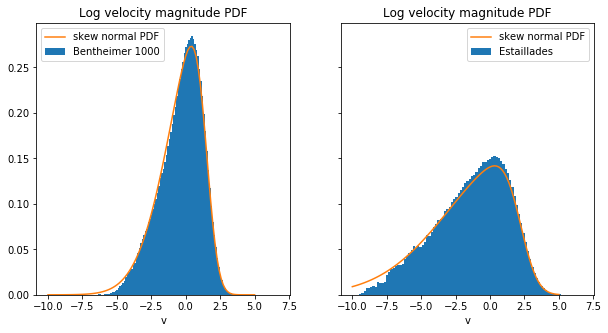

In [9]:
fig, axs = plt.subplots(1,2, figsize=(10,5), sharey=True, sharex=True)
NBINS = 100
for (i,sample) in zip(range(len(samples)),samples) :
    axs[i].hist(MP_lvm[sample['name']], bins = NBINS, density = True, log = False, label = sample['name'])
    v = np.linspace(-10,5,100)
    axs[i].plot(v,p_skew(v,sample), label = 'skew normal PDF');
    axs[i].set_title('Log velocity magnitude PDF')
    axs[i].set_xlabel('v')
    axs[i].legend()
plt.savefig(DIR+'Figures/MP_pdf'+extension)

# Loading and processing DNS data

##### Computing Ux mean from Eulerian velocities

In [10]:
UMEAN = {}
Ndat  = 1000
if (not os.path.isfile(DIR+'Processed_data/UMEAN'+str(Ndat)+'.dat')) or RERUN :
    phi   = Bentheimer1000['phi']
    print('-load ux data..')
    ux    = np.loadtxt(DIR+'Bentheimer'+str(Ndat)+'/Ux.dat')
    print('-Ux dimensions : '+str(np.shape(ux)))
 
    #First method to find Umean (direct mesh computation)
    print('-first method..')
    Umean = np.mean(ux[:][0]) #Mean flow velocity as the mean over the first yz section of the domain
    UMEAN['dmc'] = [Umean]

    #Second method (From Fortran code)
    print('-reshaping ux..')
    uux = ux.reshape(Ndat**3)
    del ux
    Umean = 0
    print('-second method..')
    for (i2,i3) in zip(range(Ndat),range(Ndat)) :
        i1 = 0
        Umean += uux[Ndat*Ndat*i3 + Ndat*i2 + i1]
    Umean = Umean/(Ndat**2)/phi
    UMEAN['fortran'] = [Umean]
    Save_data(UMEAN,DIR+'Processed_data/UMEAN'+str(Ndat)+'.dat')
    del uux
else :
    UMEAN = Load_data(DIR+'Processed_data/UMEAN'+str(Ndat)+'.dat')
    
print('=> Umean fortran = ' + str(UMEAN['fortran']) + '\t Umean dmc = ' + str(UMEAN['dmc']))
Umean = UMEAN['fortran'][0]

=> Umean fortran = [2.4514361e-09]	 Umean dmc = [7.17953958e-09]


#### Some data files 

In [13]:
DATA = {}
DM_ = ['0.0E-9',
       '1.0E-12',
       '2.0E-12', 
       '5.0E-12', 
       '1.0E-11', 
       '2.0E-11', 
       '5.0E-11', 
       '1.0E-10',
       '1.0E-9',
       '1.0E-8']
KEYS   = ['Bent 1000, D='+dm+', CSF=20' for dm in DM_] #ORDERED ARRAY OF KEYS (IMPORTANT TO SORT DATA)
for dm in DM_ : DATA['Bent 1000, D='+dm+', CSF=20'] = DIR+'Bentheimer1000/sl_out_M0_DM'+dm+'_SLSM0_TMAX1E7_CSF20.dat'

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
print('Dataset to load : ' +str(len(DATA))+'/'+str(len(color_cycle)))
COLOR = { KEYS[i] : color_cycle[i] for i in range(len(KEYS))}

Dataset to load : 10/10


In [14]:
def Extract_param (fname, param) :
    p_dict = {}
    for p_ in param :
        k  = 0
        for i in range(len(fname)) :
            if fname[i:i+len(p_)] == p_ :
                k = i+len(p_)
                break
        v_ = ''
        while (fname[k] != '_' and fname[k:k+2] != '.d') :
            v_ += fname[k]
            k  += 1
        p_dict[p_] = float(v_)
    return p_dict

In [15]:
PARAM = {}
param = ['DM','SLSM','TMAX','CSF']
for key in DATA : PARAM[key] = Extract_param (DATA[key],param)

#### Computing log velocity magnitude $$v = \ln{\left(\frac{\sqrt{u_x^2 + u_y^2 + u_z^2}}{U}\right)}$$

In [16]:
vDNS = {}; vfname = DIR+'Processed_data/vDNS.dat'
tDNS = {}; tfname = DIR+'Processed_data/tDNS.dat'

if os.path.isfile(vfname) and os.path.isfile(tfname): 
    print('Loading fnames...')
    vDNS = Load_data(vfname)
    tDNS = Load_data(tfname)
    print('Done.')

RESAVE = False
print('Checking if new data file...')
for key in DATA :
    if key not in vDNS :
        RESAVE = True
        print("missing " + key + "data..")
        with open(DATA[key], 'r') as f:
            lines   = (line for line in f if len(line)>15)
            dataDNS = np.genfromtxt(lines)
        del lines;
        tDNS[key] = dataDNS[:,0]
        print(key + '\t: NtDNS = '+str(len(tDNS[key])))
        vDNS[key] = np.array(
            [np.log(np.sqrt(ux**2+uy**2+uz**2)/Umean) 
                for (ux,uy,uz) in zip(dataDNS[:,4], dataDNS[:,5], dataDNS[:,6]) 
                if np.sqrt(ux**2+uy**2+uz**2) > 0])
        del dataDNS
if RESAVE :
    print('Saving...')
    Save_data(vDNS,DIR+'Processed_data/vDNS.dat')
    Save_data(tDNS,DIR+'Processed_data/tDNS.dat')
    print('Done.')
else : print('Done.')

Loading fnames...
Done.
Checking if new data file...
Done.


In [17]:
to_errase = []
for key in vDNS :
    if key not in DATA:
        to_errase.append(key)
for key in to_errase : del vDNS[key] 

#### DNS log velocity magnitude PDF

In [18]:
def Extract_pdf(data_, nbins = 500, dst = True) :
    pdf_ = np.histogram(data_, bins = nbins, density = dst);
    pdf_ = np.array([pdf_[1][0:-1], pdf_[0]])
    return pdf_

def Return_mean(pdf_) :
    x = pdf_[0]; y = pdf_[1];
    return np.sum(x*y)/np.sum(y)

def mean_crossing_time(tdata) :
    T_  = []
    tm1 = 0
    for t_ in tdata :
        if tm1 > t_ : #If time is set to zero again (= end of the stream line)
            T_.append(tm1)
        tm1 = t_
    N_  = len(T_)
    mean_ = sum(T_)/N_
    return mean_

In [19]:
pdf_DNS = {} #Log velocity magnitude probability density function extracted directly from DNS
vmean   = [] #Mean log velocity magnitude
MCT     = [] #Mean crossingt time
for key in KEYS :
    pdf_DNS[key] = Extract_pdf(vDNS[key])
    MCT.append(mean_crossing_time(tDNS[key]))
    vmean.append(Return_mean(pdf_DNS[key]))

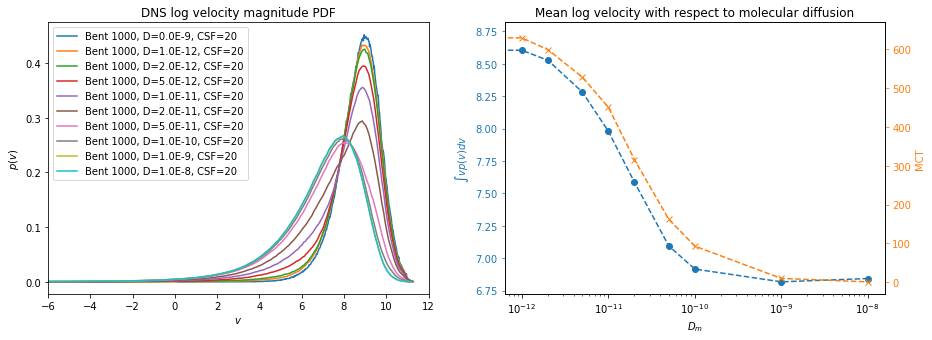

In [21]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].set_title('DNS log velocity magnitude PDF')
for key in KEYS : axs[0].plot(pdf_DNS[key][0], pdf_DNS[key][1],label = key, color = COLOR[key])
axs[0].legend();
axs[0].set_xlabel(r'$v$');
axs[0].set_ylabel(r'$p(v)$');
axs[0].set_xlim([-6,12]);

dm = [PARAM[key]['DM'] for key in KEYS]
axs[1].set_title('Mean log velocity with respect to molecular diffusion')
axs[1].semilogx(dm,vmean,'o--', color = color_cycle[0])
axs[1].set_xlabel(r'$D_m$');
axs[1].set_ylabel(r'$\int vp(v)dv$', color=color_cycle[0])
axs[1].tick_params('y', colors=color_cycle[0])

ax3 = axs[1].twinx()
ax3.semilogx(dm,MCT,'x--', color = color_cycle[1])
ax3.set_ylabel('MCT', color=color_cycle[1])
ax3.tick_params('y', colors=color_cycle[1])
plt.savefig(DIR+'Figures/DNS_lvm_pdf'+extension)

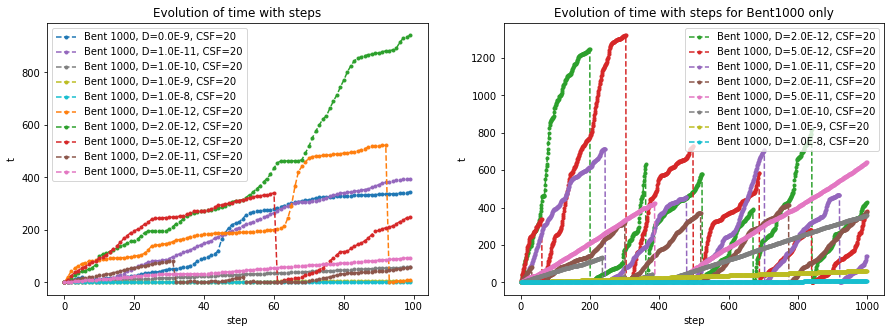

In [22]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].set_title('Evolution of time with steps');
for key in vDNS : axs[0].plot(tDNS[key][range(100)],'.--', label = key, color = COLOR[key]);
axs[0].set_xlabel('step');
axs[0].set_ylabel('t');
axs[0].legend();

axs[1].set_title('Evolution of time with steps for Bent1000 only');
for key in KEYS[2:] : axs[1].plot(tDNS[key][range(1000)],'.--', label = key, color = COLOR[key]);
axs[1].set_xlabel('step');
axs[1].set_ylabel('t');
axs[1].legend();
plt.savefig(DIR+'Figures/DNS_time'+extension)

## Making DNS data isochronous

##### Compiling streamlines into one single stream lines (ssl)

In [23]:
def ssl_transform(N,t,v) :
    dt      = [t1-t0 for (t1,t0) in zip(t[range(1,N)],t[range(N-1)])]
    dt_ssl  = [dt_ for dt_ in dt if dt_ > 0] #filtering
    N_ssl   = len(dt_ssl)
    t_ssl   = np.zeros(N_ssl)
    #t_ssl  = [t_ssl[i-1] + dt_ssl[i] for i in range(1,N_ssl)]
    T = 0.0
    for i in range(N_ssl) :
        t_ssl[i] = T
        T += dt_ssl[i]
    v_ssl   = np.array([v for (v,dt) in zip(v,dt) if dt > 0])
    return t_ssl, dt_ssl, v_ssl

In [24]:
dicts      = [{},{},{}]
v_ssl   = dicts[0]; vsslfname   = DIR+'Processed_data/v_ssl.dat'
t_ssl   = dicts[1]; tsslfname   = DIR+'Processed_data/t_ssl.dat'
dt_ssl  = dicts[2]; dtsslfname  = DIR+'Processed_data/dt_ssl.dat'
fnames     = [vsslfname, tsslfname, dtsslfname]

for i in range(len(fnames)) :
    name_ = fnames[i]
    if os.path.isfile(name_): 
        print('Loading ' + name_ + '..')
        dicts[i] = Load_data(name_)
    else : 
        print('Missing ' + name_ + '..')
        MISSING = True
    print('Done.')
v_ssl   = dicts[0];
t_ssl   = dicts[1];
dt_ssl  = dicts[2];

RESAVE = False
print('Checking if new data file...')
for key in DATA :
    if key not in v_ssl or MISSING :
        RESAVE = True
        print("missing " + key + "data..")
        Npoints = len(tDNS[key]) #For the full data set
        t_ssl[key], dt_ssl[key], v_ssl[key] = ssl_transform (Npoints, tDNS[key], vDNS[key])
        print (key + '\t Npoints = '+str(Npoints))
if RESAVE :
    print('Saving '+vsslfname+'...')
    Save_data(v_ssl,vsslfname)
    print('Saving '+tsslfname+'...')
    Save_data(t_ssl,tsslfname)
    print('Saving '+dtsslfname+'...')
    Save_data(dt_ssl,dtsslfname)
    print('Done.')    

Loading D:/pdm_data/Processed_data/v_ssl.dat..
Done.
Loading D:/pdm_data/Processed_data/t_ssl.dat..
Done.
Loading D:/pdm_data/Processed_data/dt_ssl.dat..
Done.
Checking if new data file...
missing Bent 1000, D=0.0E-9, CSF=20data..
Bent 1000, D=0.0E-9, CSF=20	 Npoints = 1946689
missing Bent 1000, D=1.0E-12, CSF=20data..
Bent 1000, D=1.0E-12, CSF=20	 Npoints = 2568389
missing Bent 1000, D=2.0E-12, CSF=20data..
Bent 1000, D=2.0E-12, CSF=20	 Npoints = 2717415
missing Bent 1000, D=5.0E-12, CSF=20data..
Bent 1000, D=5.0E-12, CSF=20	 Npoints = 3048554
missing Bent 1000, D=1.0E-11, CSF=20data..
Bent 1000, D=1.0E-11, CSF=20	 Npoints = 3641739
missing Bent 1000, D=2.0E-11, CSF=20data..
Bent 1000, D=2.0E-11, CSF=20	 Npoints = 4932688
missing Bent 1000, D=5.0E-11, CSF=20data..
Bent 1000, D=5.0E-11, CSF=20	 Npoints = 6291766
missing Bent 1000, D=1.0E-10, CSF=20data..
Bent 1000, D=1.0E-10, CSF=20	 Npoints = 8083927
missing Bent 1000, D=1.0E-9, CSF=20data..
Bent 1000, D=1.0E-9, CSF=20	 Npoints = 8203

In [26]:
dt_hist    = {}
dtDNS_mean = {}
for key in DATA : 
    dt_hist[key] = Extract_pdf(np.log(dt_ssl[key]))
    dtDNS_mean[key] = np.exp(Return_mean(dt_hist[key]))
    print (key + '\t mean time step : '+str(dtDNS_mean[key])+'\t Npoints = '+str(Npoints))

Bent 1000, D=0.0E-9, CSF=20	 mean time step : 2.6046751008416287	 Npoints = 4610471
Bent 1000, D=1.0E-12, CSF=20	 mean time step : 2.033923953228644	 Npoints = 4610471
Bent 1000, D=2.0E-12, CSF=20	 mean time step : 1.9944849945723335	 Npoints = 4610471
Bent 1000, D=5.0E-12, CSF=20	 mean time step : 1.9440277287171197	 Npoints = 4610471
Bent 1000, D=1.0E-11, CSF=20	 mean time step : 1.8016831583572828	 Npoints = 4610471
Bent 1000, D=2.0E-11, CSF=20	 mean time step : 1.513048108855972	 Npoints = 4610471
Bent 1000, D=5.0E-11, CSF=20	 mean time step : 0.9167225225853046	 Npoints = 4610471
Bent 1000, D=1.0E-10, CSF=20	 mean time step : 0.5242540233407602	 Npoints = 4610471
Bent 1000, D=1.0E-9, CSF=20	 mean time step : 0.05847532645946851	 Npoints = 4610471
Bent 1000, D=1.0E-8, CSF=20	 mean time step : 0.0058573487721939954	 Npoints = 4610471


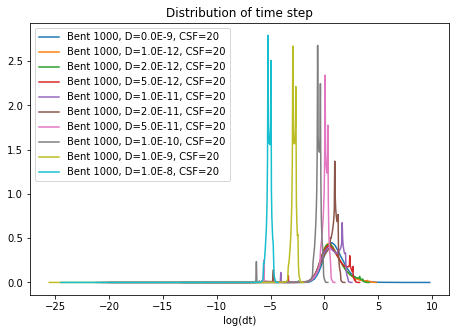

In [27]:
fig, ax = plt.subplots(1,1,figsize=(7.5,5))
for key in KEYS :
    ax.plot(dt_hist[key][0],dt_hist[key][1], label = key, color = COLOR[key])
ax.set_title('Distribution of time step');
ax.set_xlabel('log(dt)')
ax.legend();
plt.savefig(DIR+'Figures/DNS_dt_distribution'+extension)

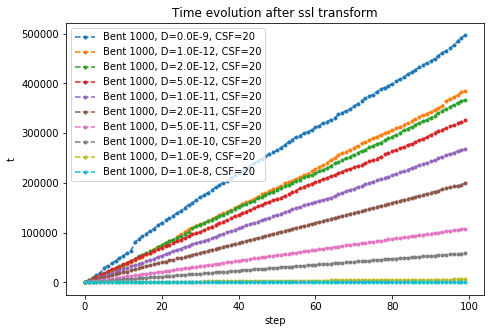

In [58]:
fig, ax = plt.subplots(1,1, figsize=(7.5,5))
ax.set_title('Time evolution after ssl transform')
for key in KEYS[0:] : ax.plot(t_ssl[key][range(0,100000,1000)],'.--', label = key, color = COLOR[key]);
ax.set_xlabel('step');
ax.set_ylabel('t');
ax.legend();
plt.savefig(DIR+'Figures/DNS_time_iso'+extension)

#### Isochronous transform of DNS data

In [33]:
#pointwise linear interpolation
def lin_interp(v1,t1,v0,t0,t) :
    v = v0 + (v1-v0) * (t-t0)/(t1-t0)
    return v
#Alternative version (parallel over dict keys) :
def isochronous_transform(t_serie, v_serie, dt, key, Npoints) :
    if Npoints == 'all' :
        T_end    = t_serie[-1]
    elif 0 < Npoints <= 1 :
        Npoints = int(Npoints * len(t_serie)) - 2
        T_end    = t_serie[Npoints]
    else :
        T_end    = t_serie[Npoints]
    Nt_iso   = int(T_end/dt)-1
    v_iso    = np.zeros(Nt_iso)
    
    v_iso[0] = v_serie[0]
    m = 0;
    t1 = t_serie[m+1]; t0 = t_serie[m];
    
    for i in range(1,Nt_iso) :
        ti  = i*dt
        while (not t0 <= ti <= t1) :
            m += 1;
            t1 = t_serie[m+1]; t0 = t_serie[m];                 
        v1 = v_serie[m+1]
        v0 = v_serie[m]
        v_iso[i]  = lin_interp(v1,t1,v0,t0,ti)
    return (key,v_iso)

def parallel_isochronous_transform(t_dict, v_dict, dt_dict, Npoints) :
    v_iso    = Parallel(n_jobs=-2)(
        delayed(isochronous_transform)
        (t_dict[key], v_dict[key], dt_dict[key], key, Npoints) for key in t_dict)
    v_iso_dict = {}
    for (key,v_) in v_iso :
        v_iso_dict[key] = v_.tolist()
    return v_iso_dict

In [62]:
#Dictionnary to store isochronous transforms with various dt
v_iso  = {}; vname = DIR+'Processed_data/v_iso.dat';
t_iso  = {} #time (linspace(0,T,dt))
Nt_iso = {} #number of points
dt_iso = {}; dtname = DIR+'Processed_data/dt_iso.dat';
RERUN  = True
RESAVE = False
Npoints = int(1.5e6)
if  (os.path.isfile(vname) and os.path.isfile(dtname)) and (not RERUN) :
    print('Load v_iso.dat...')
    v_iso = Load_data(vname)
    print('Load dt_iso.dat...')
    dt_iso = Load_data(dtname)
    print('Done.')
else :
    RESAVE = True
    start = time.time()
    v_iso  = parallel_isochronous_transform(t_ssl, v_ssl, dtDNS_mean, Npoints)
    end = time.time()
    print('\tTime needed \t: '+str(end-start))

for key in v_iso :
    print(key+' :')
    Nt_iso[key]  = len(v_iso[key])
    dt  = dtDNS_mean[key]
    dt_iso[key] = [dt]
    t_iso [key]  = np.linspace(0,tDNS[key][-1],Nt_iso[key])
    print('\t dt = '+str(dt))
    print('\t Nt_DNS = '+str(len(tDNS[key])))
    print('\t Nt_iso = '+str(Nt_iso[key]))
    print('\t Niso/Npoints inflation :'+str(100.0 * Nt_iso[key]/Npoints))
if RESAVE :
    print('Saving data...')
    Save_data(v_iso,vname)
    Save_data(dt_iso,dtname)
    print('Done.')
else : print('All data seem to be loaded.')

	Time needed 	: 9.512531757354736
Bent 1000, D=0.0E-9, CSF=20 :
	 dt = 2.6046751008416287
	 Nt_DNS = 1946689
	 Nt_iso = 2971337
	 Niso/Npoints inflation :198.08913333333334
Bent 1000, D=1.0E-12, CSF=20 :
	 dt = 2.033923953228644
	 Nt_DNS = 2568389
	 Nt_iso = 2868473
	 Niso/Npoints inflation :191.23153333333335
Bent 1000, D=2.0E-12, CSF=20 :
	 dt = 1.9944849945723335
	 Nt_DNS = 2717415
	 Nt_iso = 2784138
	 Niso/Npoints inflation :185.6092
Bent 1000, D=5.0E-12, CSF=20 :
	 dt = 1.9440277287171197
	 Nt_DNS = 3048554
	 Nt_iso = 2550376
	 Niso/Npoints inflation :170.02506666666667
Bent 1000, D=1.0E-11, CSF=20 :
	 dt = 1.8016831583572828
	 Nt_DNS = 3641739
	 Nt_iso = 2281446
	 Niso/Npoints inflation :152.0964
Bent 1000, D=2.0E-11, CSF=20 :
	 dt = 1.513048108855972
	 Nt_DNS = 4932688
	 Nt_iso = 2028689
	 Niso/Npoints inflation :135.24593333333334
Bent 1000, D=5.0E-11, CSF=20 :
	 dt = 0.9167225225853046
	 Nt_DNS = 6291766
	 Nt_iso = 1783372
	 Niso/Npoints inflation :118.89146666666667
Bent 1000

#### Verification of the isochronous transform by comparing it to original data

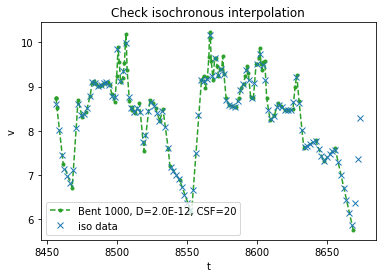

In [80]:
key    = KEYS[2]
fig, ax = plt.subplots(1,1)
ax.set_title('Check isochronous interpolation');

i0     = 2000
N      = 100
T0     = t_ssl[key][i0]
T      = t_ssl[key][i0+N]
ax.plot(t_ssl[key][i0:i0+N],v_ssl[key][i0:i0+N],'.--',color = COLOR[key], label = key); #rough DNS series

i0_iso = int(np.ceil(T0/dt_iso[key]))
N_iso  = int(np.ceil((T-T0)/dt_iso[key]))
t_iso  = np.linspace(T0,T,N_iso)
ax.plot(t_iso,v_iso[key][i0_iso:i0_iso+N_iso],'x',label='iso data'); #Isochronous series

ax.set_xlabel('t');
ax.set_ylabel('v');
ax.legend();
plt.savefig(DIR+'Figures/check_iso_transf'+extension)

#### Comparisons to summarize

In [64]:
pdf_DNS     = {} #Log velocity magnitude probability density function extracted directly from DNS
pdf_iso     = {} #to store isochronous histogram as a line
vmean       = [] #Mean log velocity magnitude
MCT         = [] #Mean crossing time
vmean_iso   = [] #Mean log velocity magnitude

for key in KEYS :
    pdf_DNS[key] = Extract_pdf(vDNS[key])
    pdf_iso[key] = Extract_pdf(v_iso[key]);
    MCT.append(mean_crossing_time(tDNS[key]))
    vmean.append(Return_mean(pdf_DNS[key]))
    vmean_iso.append(Return_mean(pdf_iso[key]))

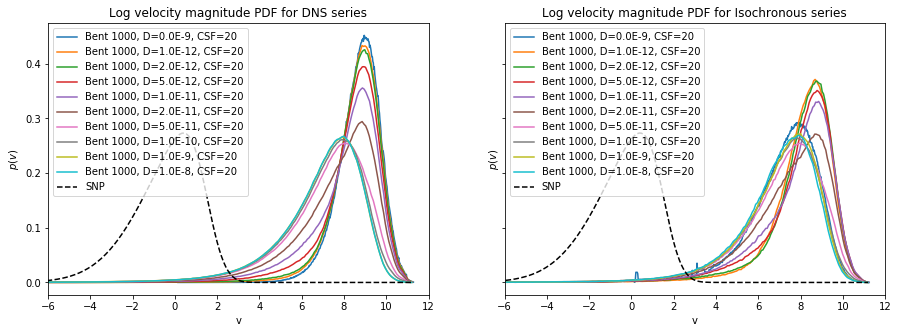

In [65]:
fig, axs = plt.subplots(1,2, figsize=(15,5), sharey=True);

axs[0].set_title('DNS log velocity magnitude PDF')
axs[0].set_title('Log velocity magnitude PDF for DNS series');
axs[0].set_xlabel('v')
axs[0].set_ylabel(r'$p(v)$')
for key in KEYS : 
    axs[0].plot(pdf_DNS[key][0],pdf_DNS[key][1], label=key, color=COLOR[key]);
axs[0].plot(pdf_DNS[key][0], p_skew(pdf_DNS[key][0],Bentheimer1000), '--k', label = 'SNP');
axs[0].legend();
axs[0].set_xlim([-6,12]);

axs[1].set_title('Log velocity magnitude PDF for Isochronous series');
axs[1].set_xlabel('v')
axs[1].set_ylabel(r'$p(v)$')
for key in KEYS : 
    axs[1].plot(pdf_iso[key][0], pdf_iso[key][1], label =key, color=COLOR[key])
axs[1].plot(pdf_iso[key][0], p_skew(pdf_iso[key][0],Bentheimer1000), '--k', label = 'SNP');
axs[1].legend();
axs[1].set_xlim([-6,12]);
plt.savefig(DIR+'Figures/DNS_vs_iso'+extension)

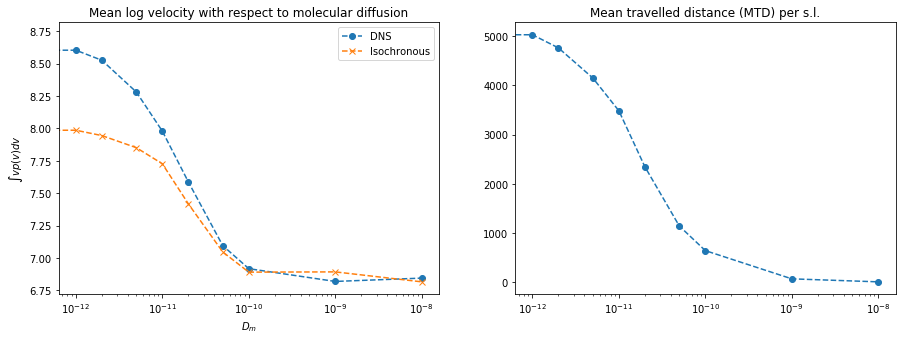

In [90]:
dm = [PARAM[key]['DM'] for key in KEYS]

fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].set_title('Mean log velocity with respect to molecular diffusion')
axs[0].semilogx(dm,vmean,'o--', color = color_cycle[0], label = 'DNS')
axs[0].semilogx(dm,vmean_iso,'x--', color = color_cycle[1], label = 'Isochronous')
axs[0].set_xlabel(r'$D_m$');
axs[0].set_ylabel(r'$\int vp(v)dv$')
axs[0].legend()

axs[1].set_title('Mean travelled distance (MTD) per s.l.')
MTD = [mct_ * vm_ for (mct_,vm_) in zip(MCT,vmean_iso)]
axs[1].semilogx(dm,MTD,'o--')
plt.savefig(DIR+'Figures/mean_v_to_dm'+extension)

## Comparing DNS data with Markov model and PDF

Umean :2.4514360982848174e-09	 np.log(Umean) :19.826591821550718


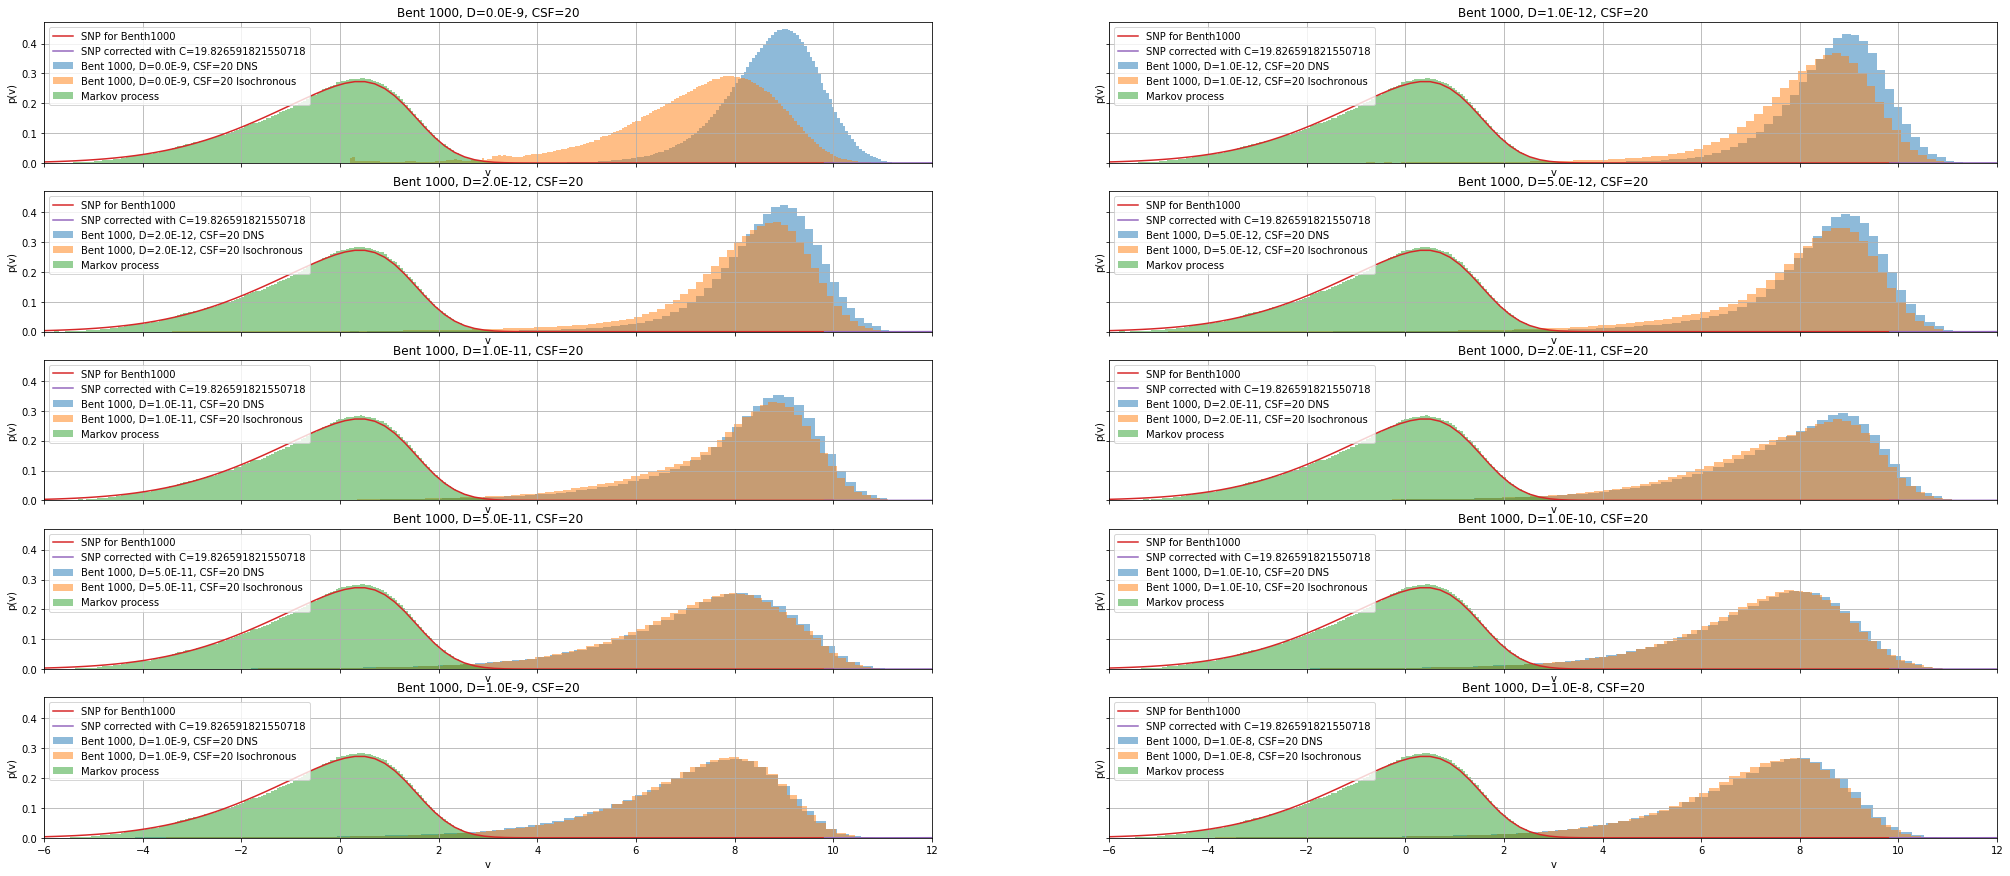

In [82]:
fig, axs = plt.subplots(5,2,figsize=(35,15), sharex=True, sharey=True)
sample   = Bentheimer1000
vrange = np.linspace(-10,10,100)
count    = 0
C=-np.log(Umean)
print('Umean :'+str(Umean)+'\t np.log(Umean) :'+str(C))
for key in KEYS :
    data1 = vDNS[key]
    data2 = v_iso[key]
    data3 = MP_lvm[sample['name']]
    (i,j) = (int(count/2),np.mod(count,2))
    axs[i,j].set_title('' + key)
    axs[i,j].hist(data1, bins = 200, label = key+' DNS',         density = True, alpha= 0.5)
    axs[i,j].hist(data2, bins = 200, label = key+' Isochronous', density = True, alpha= 0.5)
    axs[i,j].hist(data3, bins = 200, label = 'Markov process',   density = True, alpha= 0.5)
    axs[i,j].plot(vrange, p_skew(vrange,sample), label = 'SNP for Benth1000');
    axs[i,j].plot(vrange+C, p_skew(vrange,sample),  label = 'SNP corrected with C='+str(C));
    axs[i,j].grid(True)
    axs[i,j].set_xlabel('v')
    axs[i,j].set_ylabel('p(v)')
    axs[i,j].legend()
    axs[i,j].set_xlim([-6,12])
    count += 1
del data1, data2, data3
plt.savefig(DIR+'Figures/summary'+extension)